In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
tesla_df = pd.read_csv('Data/TSLA.csv')
display(tesla_df.head())
display(tesla_df.info())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3540 non-null   object 
 1   Open       3540 non-null   float64
 2   High       3540 non-null   float64
 3   Low        3540 non-null   float64
 4   Close      3540 non-null   float64
 5   Adj Close  3540 non-null   float64
 6   Volume     3540 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 193.7+ KB


None

In [45]:
# Convert the Date column to datetime format
tesla_df["Date"] = pd.to_datetime(tesla_df["Date"])

In [46]:
# We arbitrarily decide to use 2024 as the test year, and all previous years
# as the training years.
#test_data_len = len(tesla_df[tesla_df["Date"].dt.year >= 2023])
#train_data_len = len(tesla_df[tesla_df["Date"].dt.year < 2023])
train_data_len = int(len(tesla_df) * 0.8)
test_data_len  = len(tesla_df)-train_data_len

print(f"There are {test_data_len} test data points and {train_data_len} training data points.")
print(f"This equates to {(train_data_len/len(tesla_df)*100)}% of the data being train data.")
print(f"And a total of {test_data_len+train_data_len} records.")

There are 708 test data points and 2832 training data points.
This equates to 80.0% of the data being train data.
And a total of 3540 records.


In [47]:
# Capture the close prices
close_prices = tesla_df['Close'].values
close_prices = close_prices.reshape(-1, 1)
print(close_prices)

[[  1.592667]
 [  1.588667]
 [  1.464   ]
 ...
 [239.199997]
 [251.509995]
 [246.380005]]


In [48]:
# Scale the close prices to be between 0 and 1, which is ideal for neural
# networks.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)
print(scaled_close_prices)

[[0.00131893]
 [0.00130915]
 [0.00100428]
 ...
 [0.58238434]
 [0.61248827]
 [0.59994295]]


In [49]:
# Create the training dataset
#train_data = scaled_close_prices[0:int(train_data_len), :]
train_data = scaled_close_prices[:train_data_len]

X_train = []
y_train = []

# Set the size of the sliding window, in this case, arbitraily 30 days.
window_size = 30  

# Populate the X_train and y_train, using sliding windows for X.
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# LSTMs expect the input data to be in a three-dimensional array with 
# the following shape: [samples, window_size, features]
# 
# I am being very overtly clear here for my own understanding, this is new for me:
number_of_sequences_in_data_set = X_train.shape[0]
size_of_sliding_window = X_train.shape[1]
number_of_dataframe_features = 1 # in this case, because we only have closing price.

x_train = np.reshape(X_train, (number_of_sequences_in_data_set,
                               size_of_sliding_window,
                               number_of_dataframe_features))

print("Number of sequences in X Train:", number_of_sequences_in_data_set)
print("Size of Sliding Window:", size_of_sliding_window)
print("Number of dataframe features:", number_of_dataframe_features)


Number of sequences in X Train: 2802
Size of Sliding Window: 30
Number of dataframe features: 1


In [50]:
# Create the testing dataset
#test_data = scaled_close_prices[int(train_data_len):int(train_data_len+test_data_len), :]
test_data = scaled_close_prices[train_data_len - window_size:]

# Create the x_test and y_test datasets
X_test = []
y_test = close_prices[int(train_data_len):int(train_data_len+test_data_len), :]

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])

# Convert the data to a numpy array
X_test = np.array(X_test)

# Reshape the data into the shape [samples, window_size, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [51]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=32))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1, verbose=1)


/Users/brandon/OSU/.conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

2802/2802 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0016


In [52]:
# Get the model's predicted price values
predictions = scaler.inverse_transform(model.predict(X_test))


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/var/folders/yp/s2w2xp8n26bbg48x5rq8147w0000gn/T/ipykernel_65725/2050454204.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


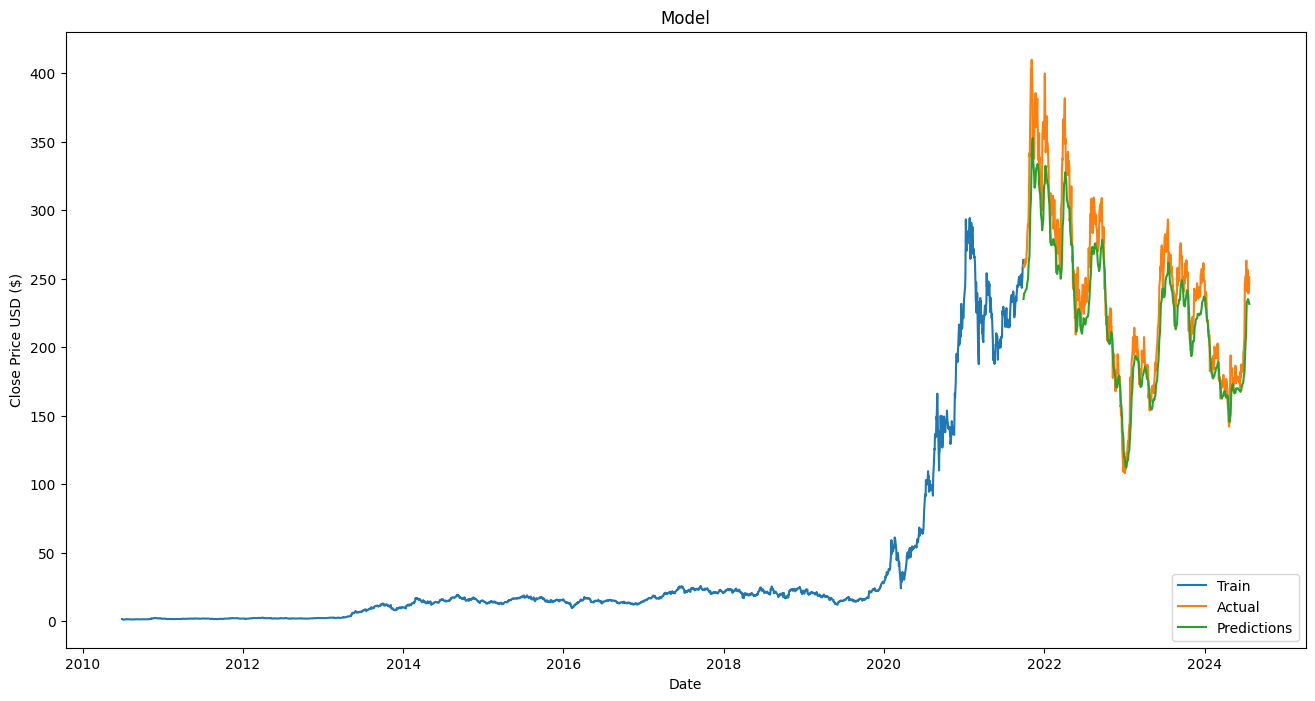

In [56]:
# Prepare the dates for the x-axis
train_dates = tesla_df['Date'][:train_data_len]
test_dates = tesla_df['Date'][train_data_len:]

# Plot the data
train = tesla_df[:train_data_len]
valid = tesla_df[train_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train_dates, train['Close'])
plt.plot(test_dates, valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()